# MA261 Assignment 4

Student ID: 2106983

---

In [1]:
import numpy as np
def npPrint(a, f={'float_kind':lambda x: "%.5e" % x}): 
   print( np.array2string(a, formatter=f) )
from matplotlib import pyplot as plt
import time

## Other functions needed

In [2]:
def newton (F, DF, x0, eps,K):
    k=0
    x=x0
    while (k<K):
        gamma=np.linalg.solve(DF(x),F(x))
        x=x-gamma
        k=k+1
        if np.linalg.norm(F(x))<eps:
            break
            
    if (np.linalg.norm(F(x0))<eps):
        x=x0
        k=0
    return x, k

In [3]:
def dirk(f,Df, t0,y0, h, alpha,beta,gamma): 
    m = len(alpha)
    n = len(y0)
    k = np.zeros((m,n))
    y = y0
    for i in range(m):
        sum=0
        for j in range(i):
            sum+=beta[i,j]*k[j]
        def F(x):
            return x-f(t0+alpha[i]*h,y0+h*sum+h*beta[i,i]*x)
        def DF(x):
            return np.eye(n)-Df(t0+alpha[i]*h,y0+h*sum+h*beta[i,i]*x)*h*beta[i,i]
        a,_=newton(F,DF,f(t0,y0),1e-15,1000)
        k[i,]=a
    for i in range (m):    
        y = y + h*gamma[i]*k[i,]
    return y
stepper1 = lambda f,Df,t0,y0,h : dirk(f,Df,t0,y0,h,alpha,beta,gamma)

In [4]:
def adaptevolve(phi, f,Df, t0,y0, T,hStart):
    t=[t0]
    y=[y0]
    t1,x,h = phi(f,Df,t0,y0,hStart)
    t.append(t1)
    y.append(x)
    i=1
    while t[-1] < T:
        ti,x,h=phi(f,Df,t[i],y[i],h)
        t.append(ti)
        y.append(x)
        i=i+1
    return np.array(t),np.array(y)

In [5]:
from scipy.integrate import solve_ivp
def evolveScipy(method, f,Df, t0,y0, T, rtol, atol):
    res = solve_ivp(f, [t0,T], y0, method=method, rtol=rtol, atol=atol)
    return res.t, res.y.transpose()

# Q 2.1.

In [6]:
mu = 200
y0=np.array([1,0])
theta=(3-2*np.log(2))*mu+2*np.pi*mu**(-1/3)
T=3.1*theta

def f(t,y):
    return np.array([y[1],mu*(1-y[0]**2)*y[1]-y[0]])

def Df(t,y):
    return np.array([[0,1],[-2*mu*y[0]*y[1]-1,mu*(1-y[0]**2)]])

In [7]:
alpha = np.array([0,1/5,3/10,3/5,1,7/8])
beta  = np.array([[0,0,0,0,0,0],[1/5,0,0,0,0,0],[3/40,9/40,0,0,0,0],[3/10,-9/10,6/5,0,0,0],
                  [-11/54,5/2,-70/27,35/27,0,0],[1631/55296,175/512,575/13824,44275/110592,253/4096,0]])
gamma = np.array([37/378,0,250/621,125/594,0,512/1771])
gammaStar = np.array([2825/27648,0,18575/48384,13525/55296,277/14336,1/4])
p=4
hmax=0.05

In [8]:
def embeddirk(f,Df,t0,y0,h0,alpha,beta,gamma,gammaStar,p,tol,hmax): 
    rtol = tol
    atol = tol*1e-2
    TOL = atol+rtol*np.linalg.norm(y0)
    E   = 2*TOL
    H   = h0
    while E > TOL:
        h = H
        y1     = dirk(f,Df,t0,y0,h,alpha,beta,gamma)
        y1star = dirk(f,Df,t0,y0,h,alpha,beta,gammaStar)
        E = 1e-40+np.linalg.norm(y1-y1star)
        H = 0.9*h*(TOL/E)**(1/p+1)
        if H < 1e-10:
            print("error, scheme is probably not working")
            break
    t1 = t0+h
    y1  = y1star
    h1 = min(hmax,h)
    return t1,y1,h1

stepper = lambda f,Df,t0,y0,h: embeddirk(f,Df,t0,y0,h,alpha,beta,gamma,gammaStar,p,tol,hmax)

In [9]:
tol=0.001
start = time.time()
t1,y1 = evolveScipy('RK45', f,Df,0,y0,T,tol,tol*1e-2)
end = time.time()
print(end - start,"seconds")
h1 = np.diff(t1)
t1h=np.delete(t1,0)

7.933287143707275 seconds


In [10]:
z=[]
for i in range(np.shape(y1)[0]-1):
    if (y1[i,0]>0 and y1[i+1,0] <0) or (y1[i,0]<0 and y1[i+1,0] >0):
        z.append(i)
thetahi=[]
for i in range(len(z)-2):
    thetahi.append(t1[z[i+2]]-t1[z[i]])
thetah=np.average(thetahi)
print("approximate period error is")
npPrint(abs(theta-thetah)/theta)

approximate period error is
8.17591e-04


In [11]:
hStart = h1[0]
tol=1e-2
start = time.time()
t2,y2 = adaptevolve(stepper,f,Df,0,y0,T,hStart)
end = time.time()
print(end - start,"seconds")
h2 = np.diff(t2)
t2h=np.delete(t2,0)

1367.857106924057 seconds


In [12]:
z=[]
for i in range(np.shape(y2)[0]-1):
    if (y2[i,0]>0 and y2[i+1,0] <0) or (y2[i,0]<0 and y2[i+1,0] >0):
        z.append(i)
thetahi=[]
for i in range(len(z)-2):
    thetahi.append(t2[z[i+2]]-t2[z[i]])
thetah=np.average(thetahi)
print("approximate period error is")
npPrint(abs(theta-thetah)/theta)

approximate period error is
2.86230e-04


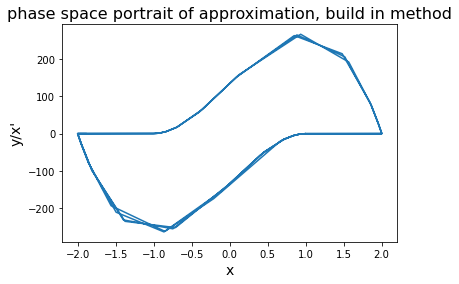

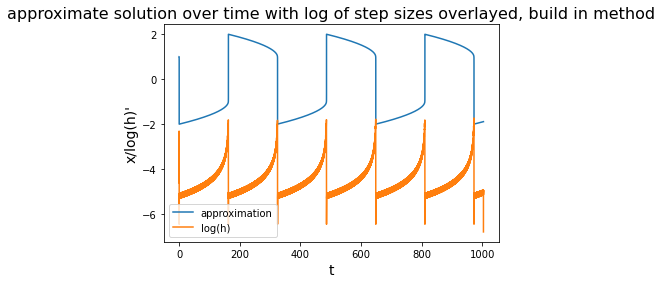

In [13]:
plt.plot(y1[:,0],y1[:,1])
plt.title("phase space portrait of approximation, build in method", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y/x'", fontsize=14)
plt.show()

plt.plot(t1,y1[:,0],label="approximation")
plt.plot(t1h,np.log(h1),label="log(h)")
plt.title("approximate solution over time with log of step sizes overlayed, build in method", fontsize=16)
plt.xlabel("t", fontsize=14)
plt.ylabel("x/log(h)'", fontsize=14)
plt.legend()
plt.show()

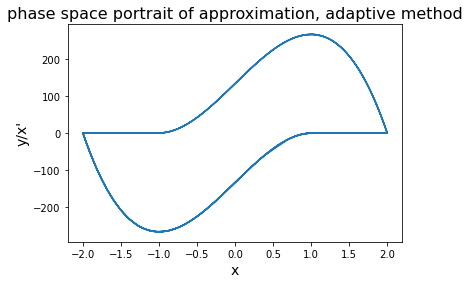

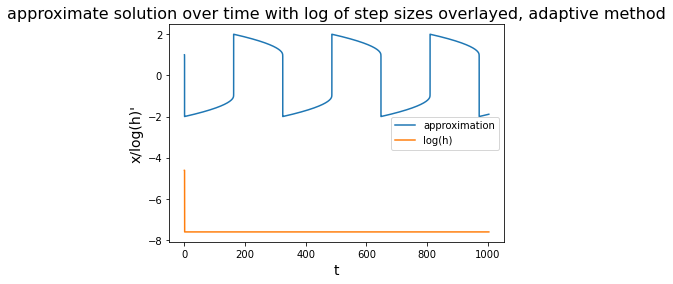

In [14]:
plt.plot(y2[:,0],y2[:,1])
plt.title("phase space portrait of approximation, adaptive method", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y/x'", fontsize=14)
plt.show()

plt.plot(t2,y2[:,0],label="approximation")
plt.plot(t2h,np.log(h2),label="log(h)")
plt.title("approximate solution over time with log of step sizes overlayed, adaptive method", fontsize=16)
plt.xlabel("t", fontsize=14)
plt.ylabel("x/log(h)'", fontsize=14)
plt.legend()
plt.show()

## Q2.1 Summary

Using the built-in method is clearly much simpler as the numerical scheme is already built into python and we can quickly and easily define a new evolve function using the built-in method. To implement the embedded adaptive method is much more cumbersome as we have to write a function that can do one step of a runge-kutta method, define our runge-kutta methods by defining the alpha,beta and gamma's, write a function that can do one step of the embedded adaptive method and then modify our existing evolve function to fit this different method as the old one is not compatible.

The time steps of the build in method can clearly be seen to increase when the appoximation is increasing/decreasing at a slower rate and then when the approxmation sharply increases or decreases at a very fast rate the time step plummets to very small and the pattern repeats. The time steps of the adaptive method are similar at the very start and then are constant for the vast majority which leads me to think my implementaion is wrong.

As can be seen in the code, the time it takes to call the build in method and return what we need is roughly 8 seconds compared to about 1400 seconds for the adaptive method so it is about 150 times quicker which is a big advantage of the build in method.

Interestingly, the negatives of the embedded adaptive method are offset by the tolerance required and by the smoothness of the solution. The tolerance required by the built in method and the adaptive method to ensure the approximation of the period is as close as we would like is $10^{-3}$ and $10^{-2}$ respectively. So the tolerance required for the adaptive method is higher and additionally, as seen in the graphs, the curve in the phase potrait is much smoother than for the built in method even for a higher tolerance.

# Q 2.2.

In [15]:
mu     = 0.012277471
mudash = 1-mu
y0=np.array([0.994,0,0,-2.00158510637908252240537862224])
theta=17.0652165601579625588917206249
T=3*theta

def D1(y):
    return ((y[0]+mu)**2+y[1]**2)**(3/2)
def D2(y):
    return ((y[0]-mudash)**2+y[1]**2)**(3/2)
def D1dx(y):
    return 3*(y[0]+mu)*((y[0]+mu)**2+y[1]**2)**(1/2)
def D2dx(y):
    return 3*(y[0]-mudash)*((y[0]-mudash)**2+y[1]**2)**(1/2)
def D1dy(y):
    return 3*y[1]*((y[0]+mu)**2+y[1]**2)**(1/2)
def D2dy(y):
    return 3*y[1]*((y[0]-mudash)**2+y[1]**2)**(1/2)
def D1invdx(y):
    return -3*(y[0]+mu)*((y[0]+mu)**2+y[1]**2)**(-5/2)
def D2invdx(y):
    return -3*(y[0]-mudash)*((y[0]-mudash)**2+y[1]**2)**(-5/2)
def D1invdy(y):
    return -3*y[1]*((y[0]+mu)**2+y[1]**2)**(-5/2)
def D2invdy(y):
    return -3*y[1]*((y[0]-mudash)**2+y[1]**2)**(-5/2)

def f(t,w):
    x,y,u,v=w
    return np.array([u,v,x+2*v-mudash*(x+mu)/D1(w)-mu*(x-mudash)/D2(w),y-2*u-mudash*y/D1(w)-mu*y/D2(w)])

def Df(t,w):
    x,y,u,v=w
    return np.array([[0,0,1,0],[0,0,0,1],
                     [1-mudash*((D1(w)-(x+mu)*D1dx(w))/D1(w)**2)-mu*((D2(w)-(x-mudash)*D2dx(w))/D2(w)**2),
                      -mudash*(x+mu)*D1invdy(w)-mu*(x-mudash)*D2invdy(w),0,2],
                     [-mudash*y*D1invdx(w)-mu*y*D2invdx(w),
                      1-mudash*((D1(w)-y*D1dy(w))/D1(w)**2)-mu*((D2(w)-y*D2dy(w))/D2(w)**2),
                      -2,0]])

In [16]:
for i in range(20):
    tol=10**(-i)
    t,x = evolveScipy('RK45', f,Df,0,y0,T,tol,tol*1e-2)
    res = np.linalg.norm(x[-1]-y0)/np.linalg.norm(y0)
    if res < 0.01:
        break
tol

1e-11

In [17]:
tol=1e-11
t1,y1 = evolveScipy('RK45', f,Df,0,y0,T,tol,tol*1e-2)
h1 = np.diff(t1)
npPrint(np.linalg.norm(y1[-1]-y0)/np.linalg.norm(y0))

3.28371e-03


In [18]:
hStart = h1[0]
tol=1e-3
t2,y2 = adaptevolve(stepper, f,Df,0,y0,T,hStart)
npPrint(np.linalg.norm(y2[-1]-y0)/np.linalg.norm(y0))

3.65934e-03


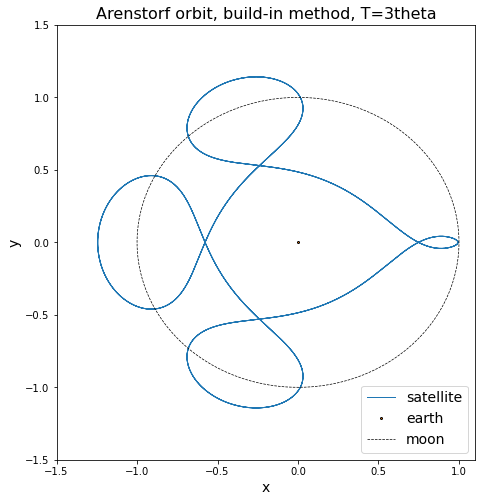

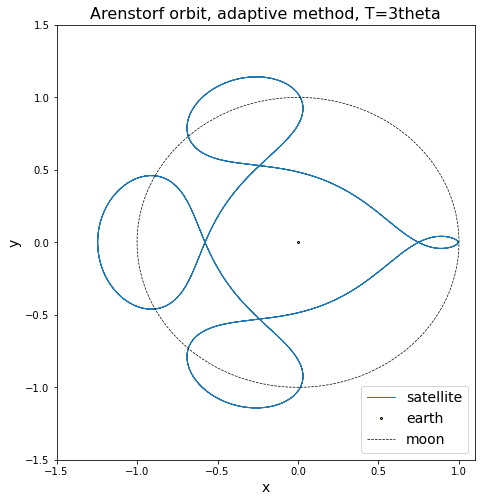

In [19]:
t=np.linspace(0,2*np.pi,1000)
plt.subplots(figsize=(7.5, 8))
plt.xlim(-1.5,1.1)
plt.ylim(-1.5,1.5)
plt.plot(y1[:,0],y1[:,1], label='satellite',linewidth=1)
plt.plot([0],[0], 'o',markersize=2, markeredgecolor="black",label='earth')
plt.plot(np.cos(t),np.sin(t),linestyle='dashed',color='black',linewidth=0.7,label='moon')
plt.title("Arenstorf orbit, build-in method, T=3theta", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

plt.subplots(figsize=(7.5, 8))
plt.xlim(-1.5,1.1)
plt.ylim(-1.5,1.5)
plt.plot(y2[:,0],y2[:,1], label='satellite',linewidth=1)
plt.plot([0],[0], 'o',markersize=2, markeredgecolor="black",label='earth')
plt.plot(np.cos(t),np.sin(t),linestyle='dashed',color='black',linewidth=0.7,label='moon')
plt.title("Arenstorf orbit, adaptive method, T=3theta", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

In [20]:
T=5*theta
for i in range(16):
    tol=10**(-i)
    t,x = evolveScipy('RK45', f,Df,0,y0,T,tol,tol*1e-2)
    res = np.linalg.norm(x[-1]-y0)/np.linalg.norm(y0)
    if res < 0.01:
        break
tol

/Users/samgrant/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


1e-15

In [21]:
tol=2.220446049250313e-14
t1,y1 = evolveScipy('RK45', f,Df,0,y0,T,tol,tol*1e-2)
h1 = np.diff(t1)
npPrint(np.linalg.norm(y1[-1]-y0)/np.linalg.norm(y0))

4.40744e-01


In [26]:
hStart = h1[0]
tol=1e-0
t2,y2 = adaptevolve(stepper, f,Df,0,y0,T,hStart)
npPrint(np.linalg.norm(y2[-1]-y0)/np.linalg.norm(y0))

6.48364e-01


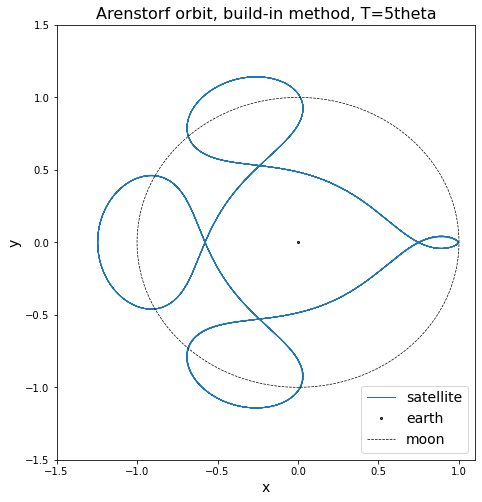

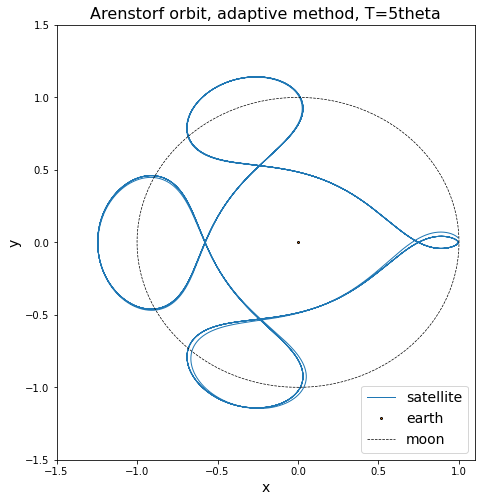

In [27]:
t=np.linspace(0,2*np.pi,1000)
plt.subplots(figsize=(7.5, 8))
plt.xlim(-1.5,1.1)
plt.ylim(-1.5,1.5)
plt.plot(y1[:,0],y1[:,1], label='satellite',linewidth=1)
plt.plot([0],[0], 'o',markersize=2, markeredgecolor="black",label='earth')
plt.plot(np.cos(t),np.sin(t),linestyle='dashed',color='black',linewidth=0.7,label='moon')
plt.title("Arenstorf orbit, build-in method, T=5theta", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

plt.subplots(figsize=(7.5, 8))
plt.xlim(-1.5,1.1)
plt.ylim(-1.5,1.5)
plt.plot(y2[:,0],y2[:,1], label='satellite',linewidth=1)
plt.plot([0],[0], 'o',markersize=2, markeredgecolor="black",label='earth')
plt.plot(np.cos(t),np.sin(t),linestyle='dashed',color='black',linewidth=0.7,label='moon')
plt.title("Arenstorf orbit, adaptive method, T=5theta", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

## Q2.2 Summary

For $T=3\theta$, the tolerances for the built in method and adaptive method such that the final value is "close" to the initial conditions are $10^{-11}$ and $10^{-3}$ respectively.

For $T=5\theta$, the minimal rtol that the built-in method allows ($2.220446049250313*10^{-14}$) is just about low enough to get a periodic orbit for the longer time period however as you can see in the code the final value is not as "close" to the initial conditions as we would like so this is not completely stable. A tolerance of $10^{-4}$ for the adaptive method produces a mostly periodic orbit but starts to deviate and again has final value not as close to the initial conditions as we would like.